### Imports

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from trainer_lib import load_country_wide_dataset, TSMWrapper
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
import os

np.random.seed(2909231846)
randomstate = np.random.RandomState(131002)

### Load data

In [2]:
df: pd.DataFrame = load_country_wide_dataset('../data/country_data.csv')

X = df.to_numpy(dtype=np.float32)
y = df['el_load'].to_numpy(dtype=np.float32)
rf_X = np.zeros((len(X)-24-3, 24*X.shape[1]))
rf_y = np.zeros((len(X)-24-3, 3))
for i in range(len(X)-24-3):
    rf_X[i] = X[i:i+24].flatten()
    rf_y[i] = y[i+24:i+24+3]

### Grid search

I'll first use grid search to get an idea of how to tune the parameters, then I'll go ahead and define some myself.

In [3]:
n_cpu = os.cpu_count()
print(f"Number of CPUs in the system: {n_cpu}, n_jobs will be set to {n_cpu-2}")

tscv = TimeSeriesSplit(n_splits=6)
split = tscv.split(rf_X, rf_y)

Number of CPUs in the system: 12, n_jobs will be set to 10


In [12]:
param_grid = {
    'n_estimators': [150, 300],
    'max_depth': [5, 15],
    'min_samples_split': [2, 5],
    'max_features': ['log2', 'sqrt', 0.5],
}
# Fitting 6 folds for each of 24 candidates, totalling 144 fits

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=randomstate, n_jobs=n_cpu-2),
    scoring='neg_root_mean_squared_error',
    param_grid=param_grid,
    cv=split,
    verbose=4,
    return_train_score=True
)

results = grid_search.fit(rf_X, rf_y)

Number of CPUs in the system: 12, n_jobs will be set to 10
Fitting 6 folds for each of 24 candidates, totalling 144 fits
[CV 1/6] END max_depth=5, max_features=log2, min_samples_split=2, n_estimators=150;, score=(train=-205.135, test=-254.296) total time=   0.5s
[CV 2/6] END max_depth=5, max_features=log2, min_samples_split=2, n_estimators=150;, score=(train=-220.561, test=-236.658) total time=   0.9s
[CV 3/6] END max_depth=5, max_features=log2, min_samples_split=2, n_estimators=150;, score=(train=-222.252, test=-275.117) total time=   1.3s
[CV 4/6] END max_depth=5, max_features=log2, min_samples_split=2, n_estimators=150;, score=(train=-230.289, test=-320.868) total time=   2.0s
[CV 5/6] END max_depth=5, max_features=log2, min_samples_split=2, n_estimators=150;, score=(train=-241.919, test=-327.881) total time=   2.5s
[CV 6/6] END max_depth=5, max_features=log2, min_samples_split=2, n_estimators=150;, score=(train=-254.395, test=-338.429) total time=   2.9s
[CV 1/6] END max_depth=5, m

In [15]:
print(f"Best parameters: {results.best_params_}")
print(f"Best score: {results.best_score_}")

# Best parameters: {'max_depth': 15, 'max_features': 0.5, 'min_samples_split': 2, 'n_estimators': 300}
# Best score: -106.06095301049247

Best parameters: {'max_depth': 15, 'max_features': 0.5, 'min_samples_split': 2, 'n_estimators': 300}
Best score: -106.06095301049247


### Estimator number tuning and train size limit

300 estimators only barely score better, it might be worth using less.
The models seem to fit worse and worse as the trainig data size increases past the 2nd fold, let's try to limit it. Maybe we are looking too far into the past.

In [13]:
tscv = TimeSeriesSplit(n_splits=6, max_train_size=rf_X.shape[0]//3)
split = tscv.split(rf_X, rf_y)

score = cross_val_score(
    RandomForestRegressor(random_state=randomstate, n_jobs=n_cpu-2, max_depth=15, max_features=0.5, min_samples_split=2, n_estimators=150),
    rf_X, rf_y,
    scoring='neg_root_mean_squared_error',
    cv=split,
    verbose=4,
)

[CV] END ............................. score: (test=-109.202) total time=  22.0s
[CV] END .............................. score: (test=-71.952) total time=  46.4s
[CV] END .............................. score: (test=-88.943) total time=  53.8s
[CV] END ............................. score: (test=-107.444) total time=  53.2s
[CV] END ............................. score: (test=-129.497) total time=  53.3s
[CV] END ............................. score: (test=-131.541) total time=  54.2s


There is mild improvement, but not much, I still want to test less estimators and maybe bring back the covid column.

### Covid column

In [14]:
df['covid'] = 0
df.loc['2020-03-11 00:00:00':'2022-03-7 23:00:00', 'covid'] = 1
df['covid'] = df['covid'].astype(float)

X = df.to_numpy(dtype=np.float32)
y = df['el_load'].to_numpy(dtype=np.float32)
rf_X = np.zeros((len(X)-24-3, 24*X.shape[1]))
rf_y = np.zeros((len(X)-24-3, 3))
for i in range(len(X)-24-3):
    rf_X[i] = X[i:i+24].flatten()
    rf_y[i] = y[i+24:i+24+3]
    
tscv = TimeSeriesSplit(n_splits=6, max_train_size=rf_X.shape[0]//2) # I'll give it more train data than before
split = tscv.split(rf_X, rf_y)
    
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [15],
    'min_samples_split': [2],
    'max_features': [0.5, 1.0],
}

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=randomstate, n_jobs=n_cpu-2),
    scoring='neg_root_mean_squared_error',
    param_grid=param_grid,
    cv=split,
    verbose=4,
    return_train_score=True
)

results = grid_search.fit(rf_X, rf_y)

Fitting 6 folds for each of 6 candidates, totalling 36 fits
[CV 1/6] END max_depth=15, max_features=0.5, min_samples_split=2, n_estimators=50;, score=(train=-27.180, test=-110.031) total time=   7.5s
[CV 2/6] END max_depth=15, max_features=0.5, min_samples_split=2, n_estimators=50;, score=(train=-29.254, test=-73.884) total time=  15.5s
[CV 3/6] END max_depth=15, max_features=0.5, min_samples_split=2, n_estimators=50;, score=(train=-29.810, test=-88.235) total time=  23.4s
[CV 4/6] END max_depth=15, max_features=0.5, min_samples_split=2, n_estimators=50;, score=(train=-33.397, test=-105.322) total time=  26.9s
[CV 5/6] END max_depth=15, max_features=0.5, min_samples_split=2, n_estimators=50;, score=(train=-36.559, test=-130.972) total time=  27.7s
[CV 6/6] END max_depth=15, max_features=0.5, min_samples_split=2, n_estimators=50;, score=(train=-42.746, test=-136.094) total time=  27.7s
[CV 1/6] END max_depth=15, max_features=0.5, min_samples_split=2, n_estimators=100;, score=(train=-26.

In [16]:
print(f"Best parameters: {results.best_params_}")
print(f"Best score: {results.best_score_}")

Best parameters: {'max_depth': 15, 'max_features': 0.5, 'min_samples_split': 2, 'n_estimators': 150}
Best score: -106.02729310577672


### Test size tuning

It might also be worth to check smaller test sizes, since we can retrain the model per month for example. I suspect as we move away from the training data, predictions get worse.

In [18]:
tscv = TimeSeriesSplit(n_splits=6, max_train_size=rf_X.shape[0]//3, test_size=24*30*2)  # 2 months of test data
split = tscv.split(rf_X, rf_y)

score = cross_val_score(
    RandomForestRegressor(random_state=randomstate, n_jobs=n_cpu-2, max_depth=15, max_features=0.5, min_samples_split=2, n_estimators=150),
    rf_X, rf_y,
    scoring='neg_root_mean_squared_error',
    cv=split,
    verbose=4,
)

print(f"Mean score: {score.mean()}")

[CV] END ............................. score: (test=-135.055) total time=  53.5s
[CV] END .............................. score: (test=-96.828) total time=  53.5s
[CV] END ............................. score: (test=-114.074) total time= 1.0min
[CV] END ............................. score: (test=-152.435) total time= 1.1min
[CV] END ............................. score: (test=-134.318) total time= 1.0min
[CV] END ............................. score: (test=-131.917) total time= 1.0min
Mean score: -127.43777719735088


We get very inconsistent testing results, I'll increase test size to 6 months.
I also want to try a higher depth.

### Depth tuning

In [19]:
tscv = TimeSeriesSplit(n_splits=6, max_train_size=rf_X.shape[0]//3, test_size=24*30*6)  # 6 months of test data
split = tscv.split(rf_X, rf_y)

score = cross_val_score(
    RandomForestRegressor(random_state=randomstate, n_jobs=n_cpu-2, max_depth=25, max_features=0.5, min_samples_split=2, n_estimators=150),
    rf_X, rf_y,
    scoring='neg_root_mean_squared_error',
    cv=split,
    verbose=4,
)

print(f"Mean score: {score.mean()}")

[CV] END .............................. score: (test=-94.696) total time= 1.1min
[CV] END ............................. score: (test=-103.579) total time= 1.1min
[CV] END ............................. score: (test=-135.493) total time= 1.0min
[CV] END ............................. score: (test=-117.599) total time= 1.1min
[CV] END ............................. score: (test=-115.701) total time= 1.1min
[CV] END ............................. score: (test=-150.475) total time= 1.1min
Mean score: -119.59061087801166


I think depth made a difference, but test size might be working against us.
I'll also remove the limit on training size.

In [24]:
df: pd.DataFrame = df.drop(columns=['covid'], errors='ignore')

X = df.to_numpy(dtype=np.float32)
y = df['el_load'].to_numpy(dtype=np.float32)
rf_X = np.zeros((len(X)-24-3, 24*X.shape[1]))
rf_y = np.zeros((len(X)-24-3, 3))
for i in range(len(X)-24-3):
    rf_X[i] = X[i:i+24].flatten()
    rf_y[i] = y[i+24:i+24+3]

tscv = TimeSeriesSplit(n_splits=6)
split = tscv.split(rf_X, rf_y)

score = cross_val_score(
    RandomForestRegressor(random_state=randomstate, n_jobs=n_cpu-2, max_depth=50, max_features=0.75, n_estimators=150),
    rf_X, rf_y,
    scoring='neg_root_mean_squared_error',
    cv=split,
    verbose=4,
)

print(f"Mean score: {score.mean()}")

[CV] END ............................. score: (test=-106.286) total time=  42.9s
[CV] END .............................. score: (test=-69.600) total time= 1.5min
[CV] END .............................. score: (test=-85.622) total time= 2.3min
[CV] END .............................. score: (test=-98.812) total time= 3.0min
[CV] END ............................. score: (test=-129.786) total time= 4.0min
[CV] END ............................. score: (test=-129.673) total time= 4.9min
Mean score: -103.29632041102292


Overall loss metrics:
MAE: 121.6123
MSE: 32896.8968
RMSE: 181.3750
MAPE:  2.817%
MPE:  1.201%
 1 hour ahead: MAE:  73.8155,  MSE: 10657.7584, RMSE: 103.2364, MAPE:  1.696%, MPE:  0.541%
 2 hour ahead: MAE: 123.6461,  MSE: 30974.6294, RMSE: 175.9961, MAPE:  2.858%, MPE:  1.147%
 3 hour ahead: MAE: 167.3755,  MSE: 57058.3025, RMSE: 238.8688, MAPE:  3.897%, MPE:  1.916%


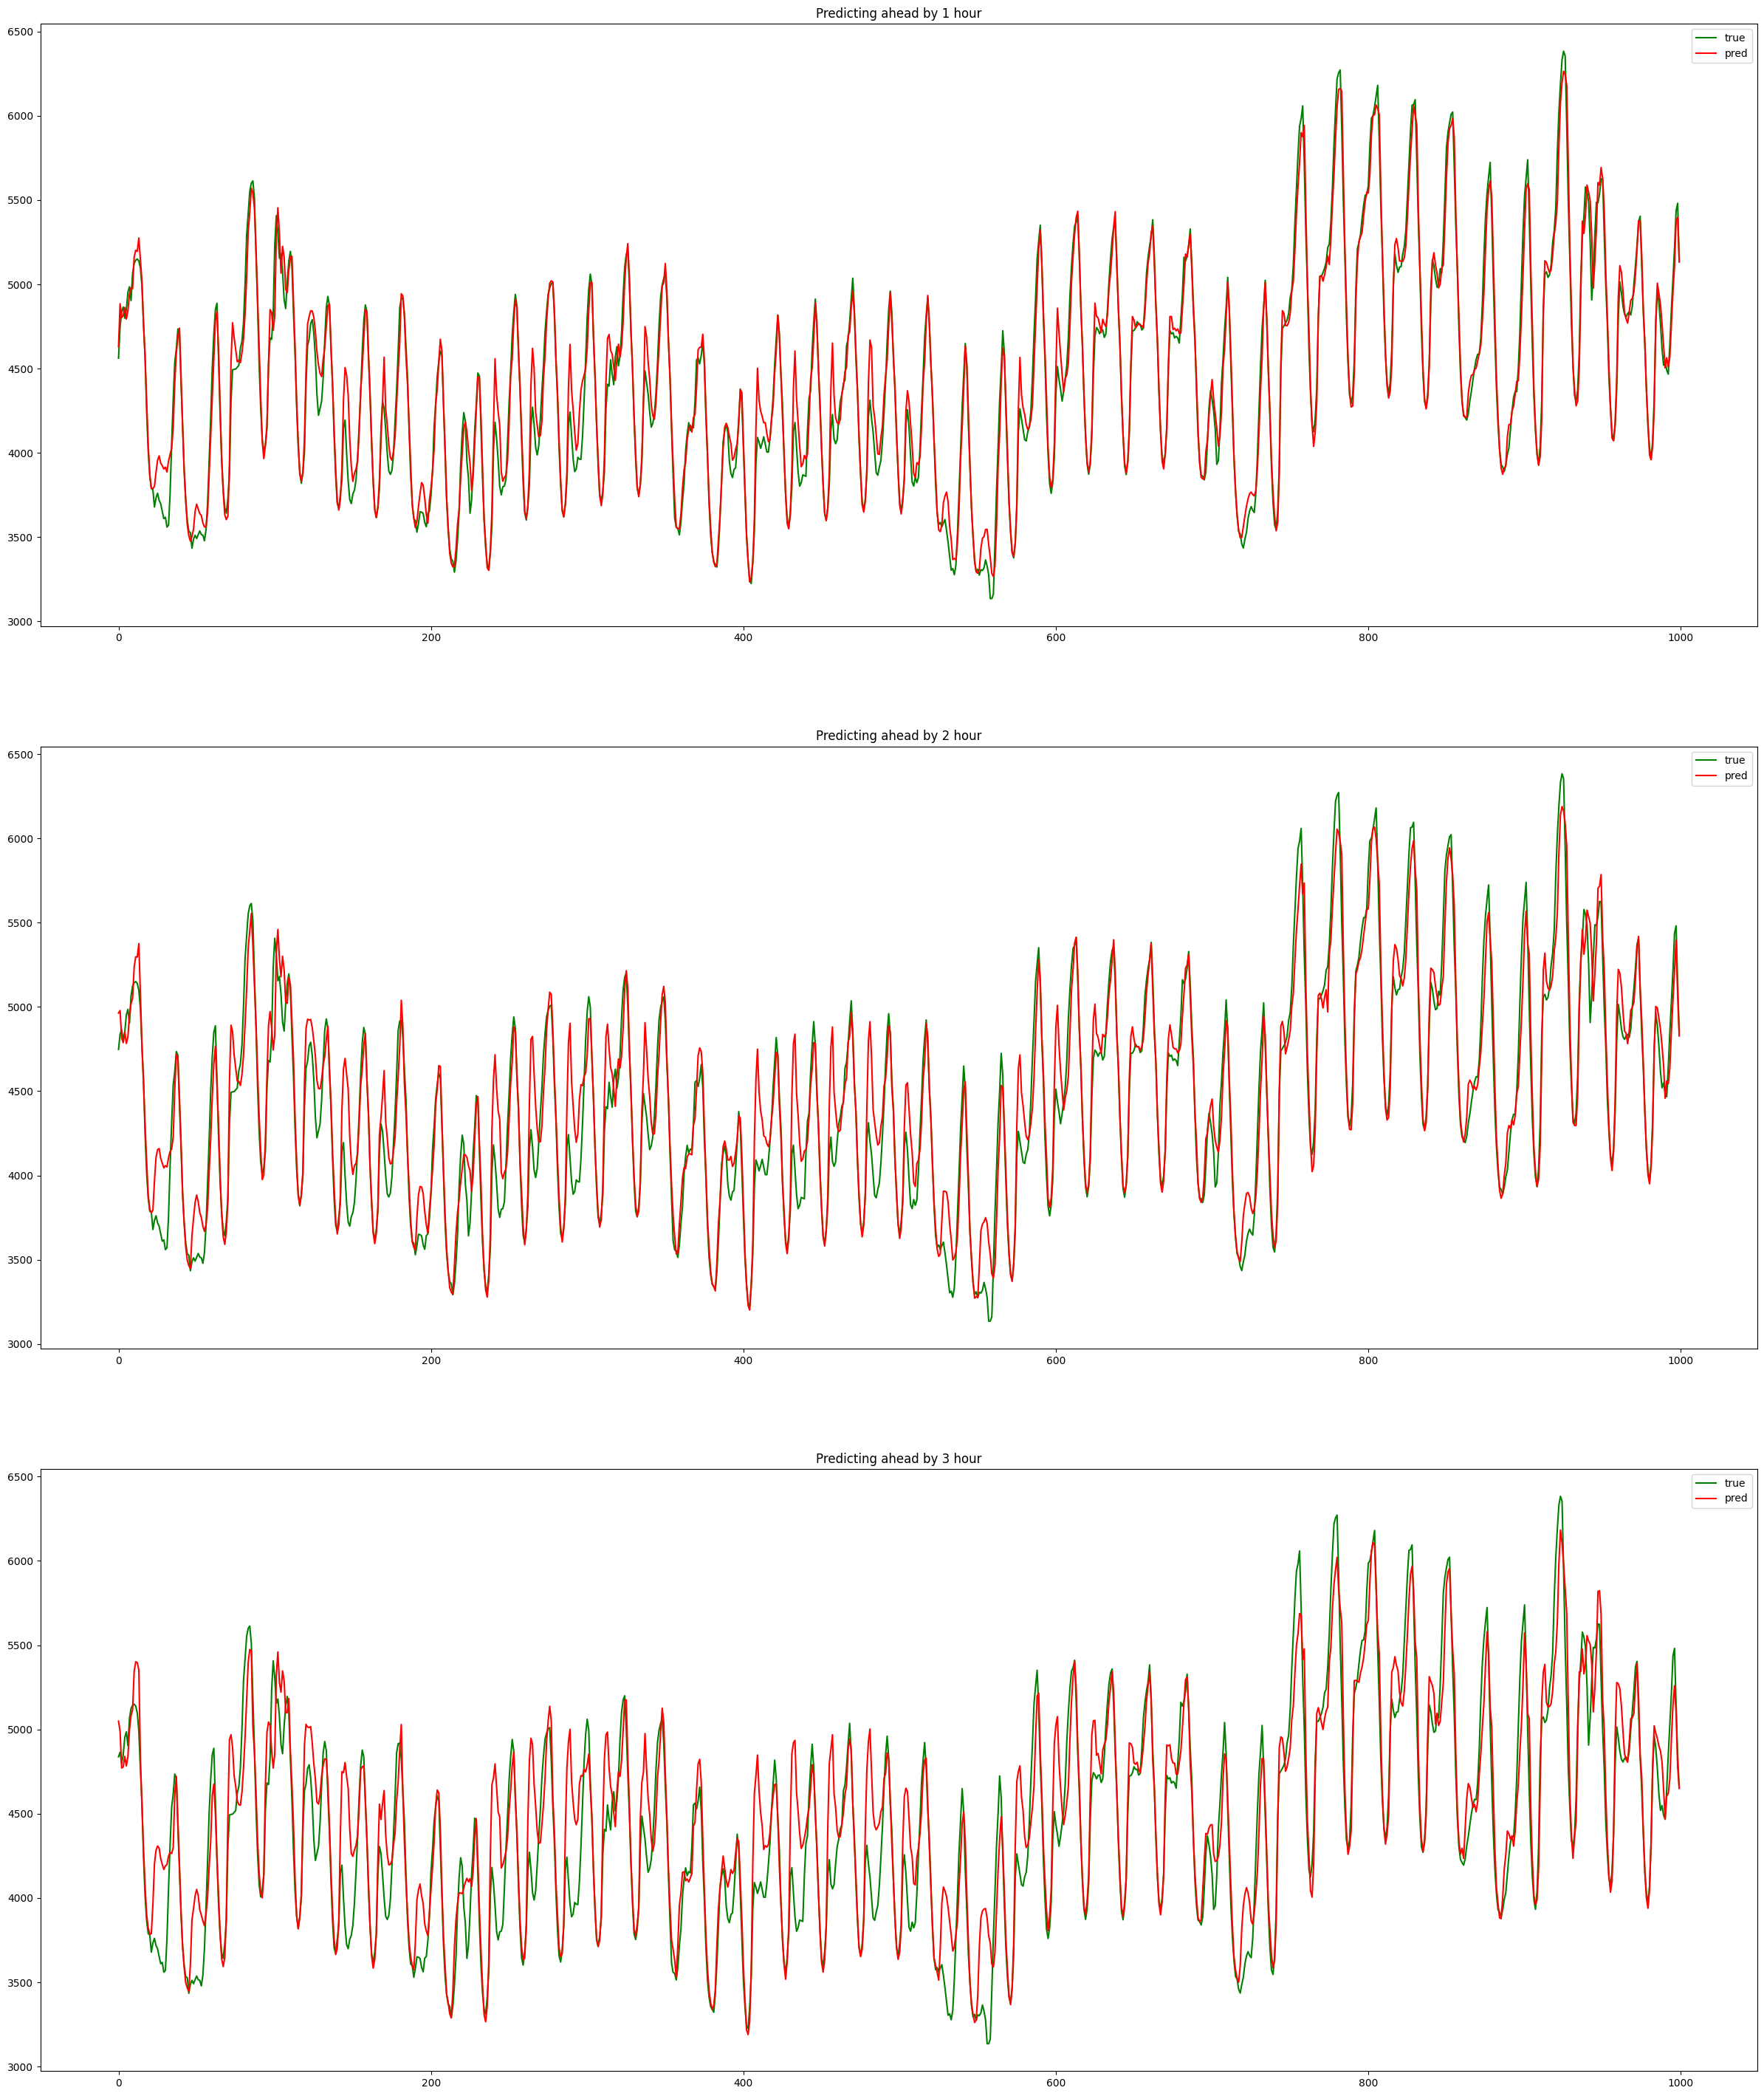

In [8]:
df: pd.DataFrame = df.drop(columns=['covid'], errors='ignore')

X = df.to_numpy(dtype=np.float32)
y = df['el_load'].to_numpy(dtype=np.float32)
rf_X = np.zeros((len(X)-24-3, 24*X.shape[1]))
rf_y = np.zeros((len(X)-24-3, 3))
for i in range(len(X)-24-3):
    rf_X[i] = X[i:i+24].flatten()
    rf_y[i] = y[i+24:i+24+3]
    
rf = RandomForestRegressor(random_state=randomstate, n_jobs=n_cpu-2, max_depth=50, max_features=0.75, n_estimators=150)
splitpoint = rf_X.shape[0]//6
rf.fit(rf_X[:-splitpoint], rf_y[:-splitpoint])

splitpoint = rf_X.shape[0] // 6 // 5  # to stay consistent with the other models
pred = rf.predict(rf_X[-splitpoint:])

TSMWrapper.print_evaluation_info(pred, rf_y[-splitpoint:])